In [5]:
import torch

class PermutationMatrixGenerator:
    def __init__(self, m):
        self.m = m
    
    def get_permutation_matrices(self, matrices):
        batch_size = matrices.size(0)

        # Compute L2 norms for rows and columns
        row_norms = matrices.norm(p=2, dim=2)  # (batch_size, m)
        col_norms = matrices.norm(p=2, dim=1)  # (batch_size, m)
        
        # Get sorted indices for rows and columns
        row_indices = torch.argsort(row_norms, dim=1, descending=True)  # (batch_size, m)
        col_indices = torch.argsort(col_norms, dim=1, descending=True)  # (batch_size, m)
        
        # Generate permutation matrices
        eye = torch.eye(self.m, device=matrices.device)
        P_r = eye[row_indices]  # (batch_size, m, m)
        P_c = eye[col_indices]  # (batch_size, m, m)
        
#         Permute rows and columns
        permuted_matrices = torch.bmm(P_r, torch.bmm(matrices, P_c.transpose(1, 2)))
        permuted_matrices = P_r@matrices@P_c.transpose(1, 2)
        permuted_matrices = matrices
        # permuted_matrices = permuted_matrices[:,col_indices,:]
        # permuted_matrices = permuted_matrices[:,:,row_indices]
        
        return permuted_matrices, P_c, P_r

# Example usage
m = 5  # Dimension of the square matrices
batch_size = 1 # Number of matrices in the batch

# Create a batch of random matrices
batch_matrices = torch.randn(batch_size, m, m)

# Initialize and use the PermutationMatrixBatch class
PMG = PermutationMatrixGenerator(m)
permuted_matrices, P_c, P_r = PMG.get_permutation_matrices(batch_matrices)

# print("Row permutation matrices:")
# print(row_perm_matrices)

# print("Column permutation matrices:")
# print(col_perm_matrices)

print("Permuted matrices:")
print(permuted_matrices.shape)


Permuted matrices:
torch.Size([1, 5, 5])


In [6]:
P_c[0]

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]])

In [7]:
P_c[0].T

tensor([[0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.]])

In [8]:
import numpy as np
a = np.array([0,4,1,3,2])

In [9]:
a

array([0, 4, 1, 3, 2])

In [10]:
a_inv = np.zeros(a.shape)
a_inv[a] = np.arange(5)

In [11]:
a_inv

array([0., 2., 4., 3., 1.])

In [12]:
np.argsort(a)

array([0, 2, 4, 3, 1])

In [13]:
# # for i in range(100):
# permuted_matrices = torch.bmm(row_perm_matrices, torch.bmm(batch_matrices, col_perm_matrices.transpose(1, 2)))
# permuted_matrices = torch.bmm(row_perm_matrices, torch.bmm(batch_matrices, col_perm_matrices.transpose(1, 2)))

In [14]:
permuted_matrices.norm(p=2, dim=2)

tensor([[2.8189, 1.3371, 2.3830, 2.0256, 1.7457]])

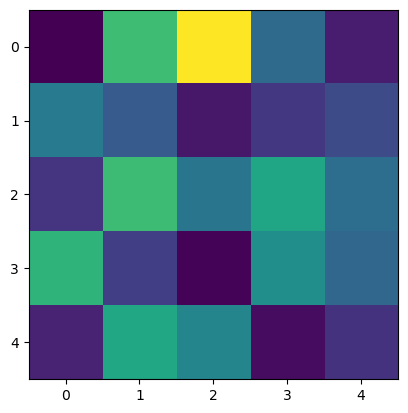

In [15]:
import matplotlib.pyplot as plt
plt.imshow(torch.abs(permuted_matrices[0]))

In [16]:
import numpy as np
F = np.load('F.npy')
F = torch.tensor(F)

In [17]:
import torch

class NormSorter:
    def __init__(self):
        pass

    def sort_rows_and_columns(self, matrices):
        """
        Sort the rows and columns of each matrix in the batch by decreasing L2 norm.
        
        Args:
            matrices (torch.Tensor): A batch of n x n matrices of shape (batch_size, n, n)
        
        Returns:
            torch.Tensor: A batch of sorted n x n matrices of shape (batch_size, n, n)
            torch.Tensor: Row sorted indices of shape (batch_size, n)
            torch.Tensor: Column sorted indices of shape (batch_size, n)
        """
        batch_size, n, _ = matrices.shape
        
        # Compute the L2 norm for rows and columns
        row_norms = torch.norm(matrices, dim=2, p=2)  # shape: (batch_size, n)
        col_norms = torch.norm(matrices, dim=1, p=2)  # shape: (batch_size, n)
        
        # Sort indices by decreasing L2 norm
        row_sorted_indices = torch.argsort(row_norms, dim=1, descending=True)  # shape: (batch_size, n)
        col_sorted_indices = torch.argsort(col_norms, dim=1, descending=True)  # shape: (batch_size, n)
        
        # Create a batch index tensor
        batch_indices = torch.arange(batch_size)#.unsqueeze(1)  # shape: (batch_size, 1)
        n_indices = torch.arange(n)

        # Sort rows using advanced indexing
        sorted_matrices = matrices[batch_indices[:,None,None], row_sorted_indices[:,:,None], col_sorted_indices[:,None,:]]  # shape: (batch_size, n, n)


        # # Transpose the matrices to sort columns
        # sorted_matrices = sorted_matrices.transpose(1, 2)  # shape: (batch_size, n, n)
        
        # # Sort columns (now rows in the transposed matrices)
        # sorted_matrices = sorted_matrices[batch_indices[:,None], col_sorted_indices]  # shape: (batch_size, n, n)
        
        # # Transpose back to original shape
        # sorted_matrices = sorted_matrices.transpose(1, 2)  # shape: (batch_size, n, n)
        
        return sorted_matrices, row_sorted_indices, col_sorted_indices

    def unsort(self, sorted_matrices, row_sorted_indices, col_sorted_indices):
        """
        Unsort the matrices back to their original order.
        
        Args:
            sorted_matrices (torch.Tensor): A batch of sorted n x n matrices of shape (batch_size, n, n)
            row_sorted_indices (torch.Tensor): Row sorted indices of shape (batch_size, n)
            col_sorted_indices (torch.Tensor): Column sorted indices of shape (batch_size, n)
        
        Returns:
            torch.Tensor: A batch of unsorted n x n matrices of shape (batch_size, n, n)
        """
        batch_size, n, _ = sorted_matrices.shape
        
        # Create inverse indices for rows and columns
        row_sorted_indices_inv = torch.argsort(row_sorted_indices, dim=1)  # shape: (batch_size, n)
        col_sorted_indices_inv = torch.argsort(col_sorted_indices, dim=1)  # shape: (batch_size, n)
        
        # Create a batch index tensor
        batch_indices = torch.arange(batch_size)#.unsqueeze(1)  # shape: (batch_size, 1)
        
        # # Unsort columns using advanced indexing
        # unsorted_matrices = sorted_matrices.transpose(1, 2)[batch_indices, col_unsorted_indices].transpose(1, 2)
        
        # # Unsort rows using advanced indexing
        # unsorted_matrices = unsorted_matrices[batch_indices, row_unsorted_indices]

        unsorted_matrices = sorted_matrices[batch_indices[:,None,None], col_sorted_indices_inv[:,:,None], row_sorted_indices_inv[:,None,:]]
        
        return unsorted_matrices

# Example usage
batch_size, n = 1, 2
# matrices = torch.rand(batch_size, n, n)
matrices = F
sorter = NormSorter()
sorted_matrices, row_sorted_indices, col_sorted_indices = sorter.sort_rows_and_columns(matrices)

print("Original matrices:")
print(matrices)
print("\nSorted matrices:")
print(sorted_matrices)

# Unsort the matrices
unsorted_matrices = sorter.unsort(sorted_matrices, row_sorted_indices, col_sorted_indices)
print("\nUnsorted matrices (should match the original):")
print(unsorted_matrices)


Original matrices:
tensor([[[-0.3390, -0.5414, -0.1431,  ...,  0.0000,  0.0000,  0.0000],
         [-0.5414, -0.7062, -0.6414,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1431, -0.6414, -1.2571,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ..., -1.2380, -0.6324, -0.1414],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.6324, -0.6965, -0.5352],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.1414, -0.5352, -0.3348]],

        [[-0.3613, -0.5799, -0.1535,  ...,  0.0000,  0.0000,  0.0000],
         [-0.5799, -0.7562, -0.6883,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1535, -0.6883, -1.3511,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ..., -1.3029, -0.6638, -0.1481],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.6638, -0.7293, -0.5596],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.1481, -0.5596, -0.3486]],

        [[-0.3337, -0.5345, -0.1415,  ...,  0.0000,  0.0000,  0.0000],
         [-0.5345, -0.6984

In [18]:
def sort_matrices(matrices):
    """
    Sort the rows and columns of each matrix in the batch by decreasing L2 norm.
    
    Args:
        matrices (torch.Tensor): A batch of n x n matrices of shape (batch_size, n, n)
    
    Returns:
        torch.Tensor: A batch of sorted n x n matrices of shape (batch_size, n, n)
        torch.Tensor: Row sorted indices of shape (batch_size, n)
        torch.Tensor: Column sorted indices of shape (batch_size, n)
    """
    batch_size, n, _ = matrices.shape
    # Compute the L2 norm for rows and columns
    row_norms = torch.norm(matrices, dim=2, p=2)  # shape: (batch_size, n)
    col_norms = torch.norm(matrices, dim=1, p=2)  # shape: (batch_size, n)
    # Sort indices by decreasing L2 norm
    row_sorted_indices = torch.argsort(row_norms, dim=1, descending=True)  # shape: (batch_size, n)
    col_sorted_indices = torch.argsort(col_norms, dim=1, descending=True)  # shape: (batch_size, n)
    # Create a batch index tensor
    batch_indices = torch.arange(batch_size)#.unsqueeze(1)  # shape: (batch_size, 1)
    n_indices = torch.arange(n)
    # Sort rows and columns using advanced indexing
    sorted_matrices = matrices[batch_indices[:,None,None], row_sorted_indices[:,:,None], col_sorted_indices[:,None,:]]  # shape: (batch_size, n, n)
    return sorted_matrices, row_sorted_indices, col_sorted_indices

def unsort_matrices(sorted_matrices, row_sorted_indices, col_sorted_indices):
    """
    Unsort the matrices back to their original order.
    
    Args:
        sorted_matrices (torch.Tensor): A batch of sorted n x n matrices of shape (batch_size, n, n)
        row_sorted_indices (torch.Tensor): Row sorted indices of shape (batch_size, n)
        col_sorted_indices (torch.Tensor): Column sorted indices of shape (batch_size, n)
    
    Returns:
        torch.Tensor: A batch of unsorted n x n matrices of shape (batch_size, n, n)
    """
    batch_size, n, _ = sorted_matrices.shape
    # Create inverse indices for rows and columns
    row_sorted_indices_inv = torch.argsort(row_sorted_indices, dim=1)  # shape: (batch_size, n)
    col_sorted_indices_inv = torch.argsort(col_sorted_indices, dim=1)  # shape: (batch_size, n)
    # Create a batch index tensor
    batch_indices = torch.arange(batch_size)#.unsqueeze(1)  # shape: (batch_size, 1)
    # # Unsort rows and columns using advanced indexing
    unsorted_matrices = sorted_matrices[batch_indices[:,None,None], col_sorted_indices_inv[:,:,None], row_sorted_indices_inv[:,None,:]]
    return unsorted_matrices

# # Example usage
# batch_size, n = 1, 2
# # matrices = torch.rand(batch_size, n, n)
# matrices = F
# sorter = NormSorter()
# sorted_matrices, row_sorted_indices, col_sorted_indices = sort_matrices(matrices)

# print("Original matrices:")
# print(matrices)
# print("\nSorted matrices:")
# print(sorted_matrices)

# # Unsort the matrices
# unsorted_matrices = unsort_matrices(sorted_matrices, row_sorted_indices, col_sorted_indices)
# print("\nUnsorted matrices (should match the original):")
# print(unsorted_matrices)


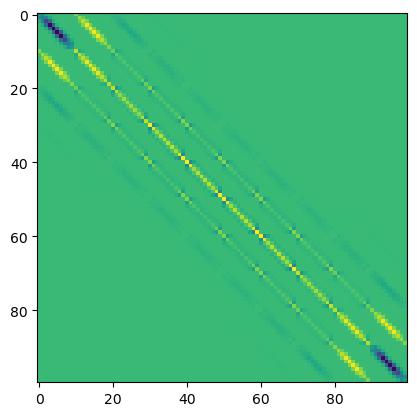

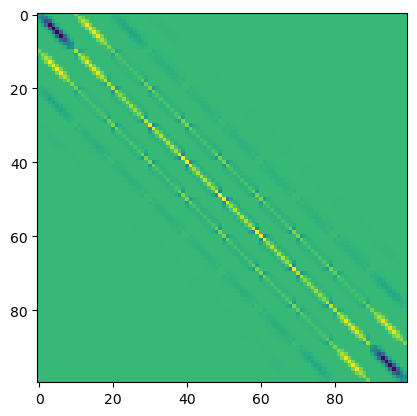

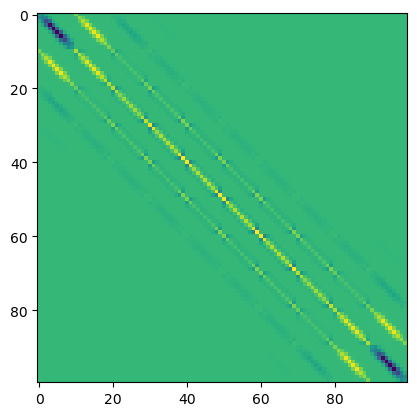

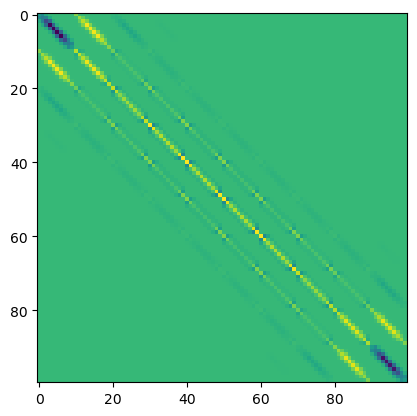

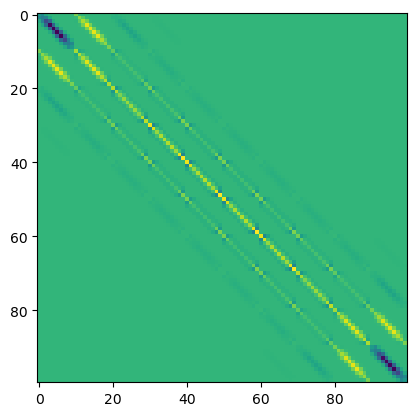

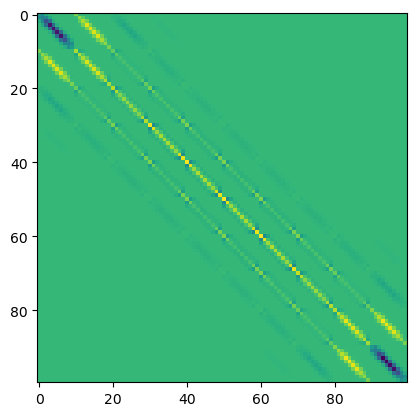

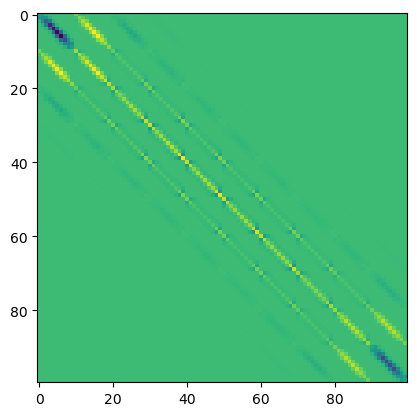

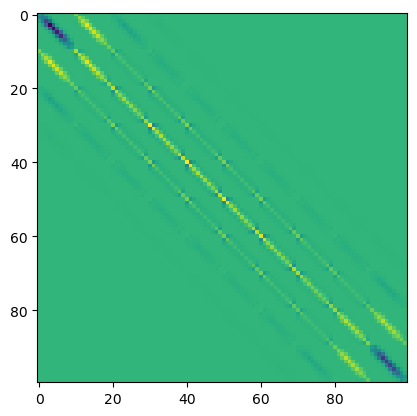

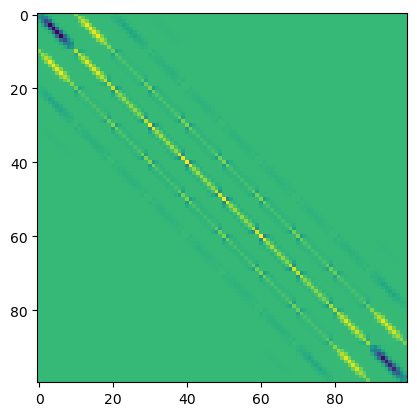

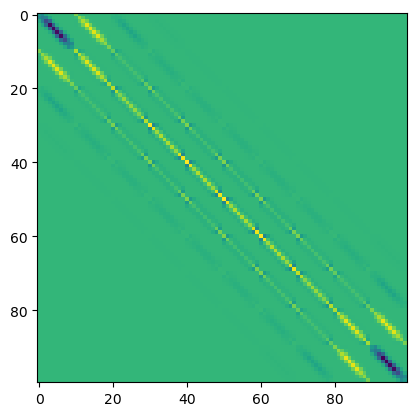

In [35]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.imshow(matrices[i])
    plt.show()
# plt.imshow(sorted_matrices[i])
# plt.show()

In [36]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from tqdm.auto import tqdm, trange
from ipywidgets import IntProgress
import time
from torch import nn
from torch.nn import functional as F

import sys
sys.path.insert(0, '../ml')
from logger import *
from trainer import train
from customlosses import *
# from systemnets import *
from basisfunctions import *

import sys
sys.path.insert(0, '../testproblems/darcy')
from NGO import NGO
from VarMiON import *
from DataModule import *

hparams = {'N_samples': 10000,
           'd': 2,
           'l_min': 0.5,
           'l_max': 1,
           'dtype': torch.float64,
           'precision': 64,
           'devices': [0],
           'loss': weightedrelativeL2,
           'metric': weightedrelativeL2,
           'optimizer': torch.optim.Adam, 
           'learning_rate': 1e-4,
           'batch_size': 100,
           'epochs': 20000,
           'modeltype': 'NGO',
           'data_based': False,
           'gamma_stabilization': 0,
           'quadrature': 'Gauss-Legendre',
           'Q': 100,
           'Q_L': 100,
           'h': [2,2],
           'p': 3,
           'C': 2,
           'n_elements': 10,
           # 'systemnet': UNet,
           'kernel_sizes': [2,2,1,1,1,1,2,2],
           'N_w': 50000,
           'bottleneck_size': 18,
           'NLB_outputactivation': nn.Tanhshrink(),
           'bias_NLBranch': False,
           'bias_LBranch': False,
           'scaling_equivariance': False}

hparams['N'] = np.prod(hparams['h'])
hparams['test_bases'] = [BSplineBasis1D(h=hparams['h'][0], p=hparams['p'], C=hparams['C']), 
                         BSplineBasis1D(h=hparams['h'][1], p=hparams['p'], C=hparams['C'])]
hparams['trial_bases'] = [BSplineBasis1D(h=hparams['h'][0], p=hparams['p'], C=hparams['C']), 
                         BSplineBasis1D(h=hparams['h'][1], p=hparams['p'], C=hparams['C'])]
# hparams['test_bases'] = [ChebyshevTBasis1D(h=hparams['h'][0]), 
#                          ChebyshevTBasis1D(h=hparams['h'][1])]
# hparams['trial_bases'] = [ChebyshevTBasis1D(h=hparams['h'][0]), 
#                          ChebyshevTBasis1D(h=hparams['h'][1])]

params = {}
params['hparams'] = hparams

In [61]:
class UNet(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.hparams = params['hparams']
        #Balancing the number of trainable parameters to N_w
        self.num_channels = 1
        count = 0
        num_channels_list = []
        while count < self.hparams['N_w']:
            self.init_layers()
            count = sum(p.numel() for p in self.parameters())
            num_channels_list.append(self.num_channels)
            self.num_channels +=1
        self.num_channels = num_channels_list[-2]
        self.init_layers()
        
    def init_layers(self):
        self.layers = nn.ModuleList()
        self.kernel_sizes = self.hparams['kernel_sizes']
        self.bottleneck_size = self.hparams['bottleneck_size']
        #Layers
        self.layers.append(ReshapeLayer(output_shape=(1,self.hparams['N'],self.hparams['N'])))
        self.layers.append(nn.Conv2d(in_channels=1, out_channels=self.num_channels, kernel_size=self.kernel_sizes[0], stride=self.kernel_sizes[0], bias=self.hparams.get('bias_NLBranch', True)))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Conv2d(in_channels=self.num_channels, out_channels=self.num_channels, kernel_size=self.kernel_sizes[1], stride=self.kernel_sizes[1], bias=self.hparams.get('bias_NLBranch', True)))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Conv2d(in_channels=self.num_channels, out_channels=self.num_channels, kernel_size=self.kernel_sizes[2], stride=self.kernel_sizes[2], bias=self.hparams.get('bias_NLBranch', True)))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Conv2d(in_channels=self.num_channels, out_channels=self.bottleneck_size, kernel_size=self.kernel_sizes[3], stride=self.kernel_sizes[3], bias=self.hparams.get('bias_NLBranch', True)))
        self.layers.append(ReshapeLayer(output_shape=(int(self.bottleneck_size),)))
        self.layers.append(nn.Linear(in_features=int(self.bottleneck_size), out_features=int(self.bottleneck_size)))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(ReshapeLayer(output_shape=(self.bottleneck_size,1,1)))
        self.layers.append(nn.ConvTranspose2d(self.bottleneck_size, self.num_channels, kernel_size=self.kernel_sizes[4], stride=self.kernel_sizes[4], bias=self.hparams.get('bias_NLBranch', True)))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.ConvTranspose2d(self.num_channels, self.num_channels, kernel_size=self.kernel_sizes[5], stride=self.kernel_sizes[5], bias=self.hparams.get('bias_NLBranch', True)))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.ConvTranspose2d(self.num_channels, self.num_channels, kernel_size=self.kernel_sizes[6], stride=self.kernel_sizes[6], bias=self.hparams.get('bias_NLBranch', True)))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.ConvTranspose2d(self.num_channels, 1, kernel_size=self.kernel_sizes[7], stride=self.kernel_sizes[7], bias=self.hparams.get('bias_NLBranch', True)))
        self.layers.append(ReshapeLayer(output_shape=(self.hparams['N'],self.hparams['N'])))
        if self.hparams['NLB_outputactivation'] is not None:
            self.layers.append(self.hparams['NLB_outputactivation'])

    def forward(self, x):
        if self.hparams.get('scaling_equivariance',False)==True:
            x_norm = torch.amax(torch.abs(x), dim=(-1,-2))
            x = x/x_norm[:,None,None]
        x, row_sorted_indices, col_sorted_indices = sort_matrices(x)
        x0 = x
        x1 = self.layers[0](x0)
        x2 = self.layers[1](x1)
        x3 = self.layers[2](x2)
        x4 = self.layers[3](x3)
        x5 = self.layers[4](x4)
        x6 = self.layers[5](x5)
        x7 = self.layers[6](x6)
        x8 = self.layers[7](x7)
        x9 = self.layers[8](x8)
        x10 = self.layers[9](x9)
        x11 = self.layers[10](x10) + x9
        x12 = self.layers[11](x11)
        x13 = self.layers[12](x12)
        x14 = self.layers[13](x13) + x7
        x15 = self.layers[14](x14)
        x16 = self.layers[15](x15) + x5
        x17 = self.layers[16](x16)
        x18 = self.layers[17](x17) + x3
        x19 = self.layers[18](x18) + x1
        x20 = self.layers[19](x19)
        x21 = self.layers[20](x20)
        y = x21
        y = unsort_matrices(y, row_sorted_indices, col_sorted_indices)
        if self.hparams.get('scaling_equivariance',False)==True:
            y = y/x_norm[:,None,None]    
        return y


In [62]:
model = UNet(params)

In [63]:
x = torch.arange(16).reshape((1,4,4))
x


tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]]])

In [64]:
# x = torch.rand(hparams['batch_size'],hparams['N'],hparams['N'])
x = torch.arange(16, dtype=torch.float32).reshape((1,4,4))

In [65]:
model(x)

tensor([[[-2.1839e-02,  2.3936e-02,  1.1825e+00,  1.3725e-01],
         [ 1.5196e+00,  5.9788e+00,  8.7559e-01,  1.1340e+01],
         [ 5.8966e+00,  6.4181e+00,  6.4721e+00,  7.5904e+00],
         [-1.3044e+00,  2.3254e+01, -3.0097e+00,  2.7438e+01]]],
       grad_fn=<IndexBackward0>)

In [66]:
P = torch.tensor([[0,1,0,0],[1,0,0,0],[0,0,1,0],[0,0,0,1]],dtype=torch.float32)
P@x

tensor([[[ 4.,  5.,  6.,  7.],
         [ 0.,  1.,  2.,  3.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]]])

In [67]:
P@model(x)@P - model(P@x@P)

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], grad_fn=<SubBackward0>)

In [7]:
import matplotlib.pyplot as plt

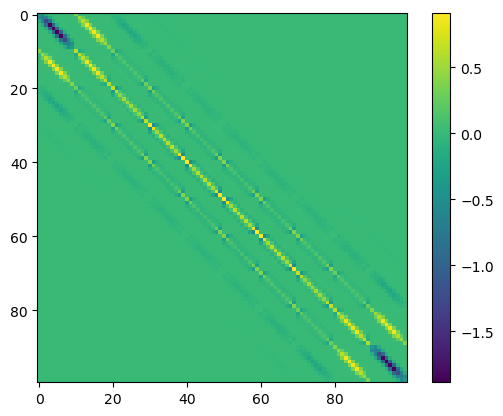

In [8]:
plt.imshow(matrices[0])
plt.colorbar()

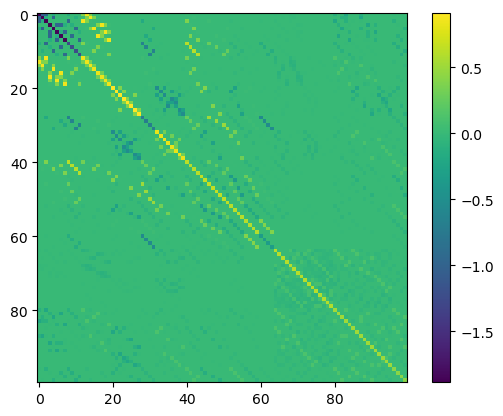

In [10]:
plt.imshow(sorted_matrices[0])
plt.colorbar()

In [42]:
A = np.random.uniform(size=(3,3))
A

array([[0.34832615, 0.45990711, 0.6183064 ],
       [0.20536121, 0.67742789, 0.87293763],
       [0.20903602, 0.6728025 , 0.40806258]])

In [49]:
A_inv = np.linalg.inv(A)
A_inv

array([[ 4.7803436 , -3.51092613,  0.26736714],
       [-1.51730184, -0.1982146 ,  2.72307845],
       [ 0.05288515,  2.12533411, -2.17609603]])

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 5.0/5.0 MB 12.8 MB/s eta 0:00:00
     ---------------------------------------- 4.0/4.0 MB 16.0 MB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 GB 828.3 kB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1


In [43]:
P = np.array([[0,1,0],[1,0,0],[0,0,1]])

In [45]:
P@A

array([[0.20536121, 0.67742789, 0.87293763],
       [0.34832615, 0.45990711, 0.6183064 ],
       [0.20903602, 0.6728025 , 0.40806258]])

In [48]:
PA_inv = np.linalg.inv(P@A)
PA_inv

array([[-3.51092613,  4.7803436 ,  0.26736714],
       [-0.1982146 , -1.51730184,  2.72307845],
       [ 2.12533411,  0.05288515, -2.17609603]])